In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import json
from pathlib import Path
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import scipy.stats as stats

# EDA

## Datasummary information

In [2]:
#Get the data extracted from different sources
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)

(9974, 20)

In [3]:
#check for datatypes
display(house_df.dtypes)

district                               object
is_incumbent                          float64
name                                   object
party                                  object
percent                               float64
state                                  object
votes                                 float64
won                                     int64
year                                    int64
first_time_elected                    float64
count_victories                         int64
unemployement_rate                    float64
is_presidential_year                  float64
president_can_be_re_elected           float64
president_party                        object
president_overall_avg_job_approval    float64
last_D_house_seats                    float64
last_R_house_seats                    float64
last_house_majority                    object
fundraising                           float64
dtype: object

In [4]:
display(house_df.head())

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#get columns with NaN data
house_df.isna().sum()

district                                 0
is_incumbent                           112
name                                     0
party                                    0
percent                                 15
state                                    0
votes                                   67
won                                      0
year                                     0
first_time_elected                    4445
count_victories                          0
unemployement_rate                     979
is_presidential_year                   102
president_can_be_re_elected            102
president_party                        102
president_overall_avg_job_approval    1060
last_D_house_seats                     102
last_R_house_seats                     102
last_house_majority                    102
fundraising                           7172
dtype: int64

In [6]:
#data normalisation
def normalise_df(df, mins, maxs):
    df = (df - mins)/(maxs - mins)
    return df

In [7]:
def clean_nan_model(data):
    #model based imputation for columns fundraising and president_overall_avg_job_approval
    #data: dataframe which is cleaned of NaNs but not for the 2 mentioned variables
    
    #These are the 2 columns which will be imputed
    missing_cols = ['fundraising', 'president_overall_avg_job_approval']
        
    data_origin = data.copy()
    target_col = ['party'] #response variable
    
    #category variables will be dropped
    del_columns = ['district','president_party','last_house_majority', 'name', 'state']
    data = data.drop(columns = del_columns)
    
    #model can not deal with NaN values so we change them to the number 1 which didn't occur in the orignal dataset
    #for those columns in missing_cols
    data = data[missing_cols].fillna(1)

    # dataset without any missing values; not normalised
    clean_data = data[~((data[missing_cols[0]]==1) | 
                      (data[missing_cols[1]]==1))]
    
    # dataset with missing values that need to be imputed; not normalised
    unclean_data = data[((data[missing_cols[0]]==1) | 
                      (data[missing_cols[1]]==1))]
    
    unclean_df = unclean_data.copy() # making fresh copy of unclean dataset
    train_data = data.copy() #start with original dataset
        
    # running for 20 iterations for robustness
    for it in range(20):
        # finding missing values to be imputed using multiple linear regression model
        for col in missing_cols:
            sub_train = train_data
            sub_test = unclean_data[unclean_data[col] == 1] # subset of unclean data with missing values in given column
            
            #split the data
            sub_xtrain, sub_ytrain = sub_train[sub_train.columns.difference([col]+target_col)], sub_train[col]
            sub_xtest, sub_ytest = sub_test[sub_test.columns.difference([col]+target_col)], sub_test[col] # sub_ytest is ones

            # normalising the train and test predictors
            sub_mins, sub_maxs = sub_xtrain.min(), sub_xtrain.max()
            sub_xtrain = normalise_df(sub_xtrain, sub_mins, sub_maxs)
            sub_xtest = normalise_df(sub_xtest, sub_mins, sub_maxs)    

            #Imputation with linear regression
            linreg = LinearRegression(fit_intercept=True)
            linreg.fit(sub_xtrain, sub_ytrain)
            sub_ytest_hat = linreg.predict(sub_xtest)

            # impute values in the unclean dataframe
            unclean_df[col].replace([1]*len(sub_ytest_hat), sub_ytest_hat, inplace=True)  

            # re-construct the train dataset by combining clean data with newly imputed values
            train_data = unclean_df.append(clean_data)
            
    return  train_data[missing_cols]

In [8]:
#get rid of NaNs
def clean_nan(data,i_type='mean'):
    #cleans NaNs
    #data: dataframe
    #i_type: if mean -> mean imputation only
    #           if model -> model imputation for undraising and president_overall_avg_job_approval
    
    #delete duplicates
    data = data.drop_duplicates(['year', 'state', 'district', 'name'])
    
    #needed just in case if not all NaNs are imputed with aggregated mean for fundraising below
    mean_fund = data.fundraising.mean()
    
    #groups needed for imputation
    gr_dist = data.groupby(['state', 'district'])
    gr_year = data.groupby(['state', 'district','year'])
    
    #imputation of values
    if i_type == 'mean':
        data['president_overall_avg_job_approval'].fillna(gr_dist['president_overall_avg_job_approval'].transform('mean'), inplace=True)
        data['fundraising'].fillna(gr_dist['fundraising'].transform('mean'), inplace=True)
        data['fundraising'].fillna(mean_fund, inplace=True) #necessary if in first fundraising imputation NaNs remain
    else:
        model_df = clean_nan_model(data)
        data['fundraising'] = model_df.fundraising
        data['president_overall_avg_job_approval']=model_df.president_overall_avg_job_approval
    data['votes'].fillna(gr_dist['votes'].transform('mean'), inplace=True)
    data['last_D_house_seats'].fillna(gr_dist['last_D_house_seats'].transform('mean'), inplace=True)
    data['last_R_house_seats'].fillna(gr_dist['last_R_house_seats'].transform('mean'), inplace=True)
    data['percent'].fillna(100 - gr_year['percent'].transform('sum'), inplace=True)
    data['unemployement_rate'].fillna(gr_dist['unemployement_rate'].transform('mean'), inplace=True)
    data['is_presidential_year'].fillna(0, inplace=True)
    data['president_can_be_re_elected'].fillna(1, inplace=True)
    data['president_party'].fillna(0, inplace=True)
    s = gr_year['is_incumbent'].transform("sum")
    r=[]
    for index, item in enumerate(s):
        if s[item] > 0:
            r.append(0)
        else:
            r.append(1)
    r = pd.Series(r)
    data['is_incumbent'].fillna(r, inplace=True)
    data['last_house_majority'].fillna(gr_dist['last_house_majority'].transform(lambda x: x.value_counts().index[0]), inplace=True)
    data.loc[data['first_time_elected'].isna() & (data['won']==1),'first_time_elected'] = data.year
    data.loc[data['first_time_elected'].isna() & (data['won']==0),'first_time_elected'] = 0

    return data

In [9]:
#clean orignal dataset nan_df with mean only
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df_mean = clean_nan(house_df,i_type='mean')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
#test if imputation worked well
house_df_mean.isna().sum()

district                              0
is_incumbent                          0
name                                  0
party                                 0
percent                               0
state                                 0
votes                                 0
won                                   0
year                                  0
first_time_elected                    0
count_victories                       0
unemployement_rate                    0
is_presidential_year                  0
president_can_be_re_elected           0
president_party                       0
president_overall_avg_job_approval    0
last_D_house_seats                    0
last_R_house_seats                    0
last_house_majority                   0
fundraising                           0
dtype: int64

In [11]:
#model based imputation
house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df_model = clean_nan(house_df, i_type='model')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C

In [12]:
#test if model based imputation worked
house_df_model.isna().sum()

district                              0
is_incumbent                          0
name                                  0
party                                 0
percent                               0
state                                 0
votes                                 0
won                                   0
year                                  0
first_time_elected                    0
count_victories                       0
unemployement_rate                    0
is_presidential_year                  0
president_can_be_re_elected           0
president_party                       0
president_overall_avg_job_approval    0
last_D_house_seats                    0
last_R_house_seats                    0
last_house_majority                   0
fundraising                           0
dtype: int64

In [13]:
#save model and mean imputed data to csv
house_df_mean.to_csv('data/house_mean_imputation.csv', index=False)
house_df_model.to_csv('data/house_model_imputation.csv', index=False)

In [14]:
#palettes for parties or other
Parties_palette=[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
             (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
             (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
WinLosePalette=[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
DEM_blue=Parties_palette[0]
REP_red=Parties_palette[1]
#sns.palplot(Parties_palette)

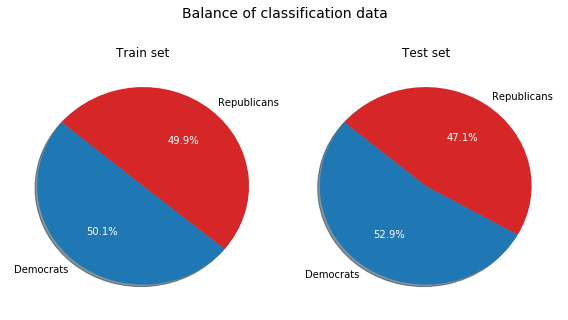

In [15]:
#check balance of classification data
test_D = len(house_df_mean[(house_df_mean['won']==1) & (house_df_mean['party']=='D')& (house_df_mean['year']==2018)])
test_R = len(house_df_mean[(house_df_mean['won']==1) & (house_df_mean['party']=='R')& (house_df_mean['year']==2018)])
train_D = len(house_df_mean[(house_df_mean['won']==1) & (house_df_mean['party']=='D')& (house_df_mean['year']!=2018)])
train_R = len(house_df_mean[(house_df_mean['won']==1) & (house_df_mean['party']=='R')& (house_df_mean['year']!=2018)])

labels = ['Democrats', 'Republicans']
sets = ['Train set', 'Test set']
sizes = [[train_D,train_R],[test_D,test_R]]
colors = [DEM_blue,REP_red]
 
fig = plt.figure(figsize=(8,4))
fig.suptitle('Balance of classification data', y=1.1,fontsize=14)
for i in range(len(sizes)):
    plt.subplot(1,2,i+1)
    _,_ , autotexts = plt.pie(sizes[i], labels=labels, colors=colors, \
                                 autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(sets[i])    
    for autotext in autotexts:
        autotext.set_color('white')
fig
plt.tight_layout()

In [16]:
#Get correlations between variables  when Democrats or Republicans win
def corr_heat(dataframe,party='D'):
    f, ax = plt.subplots(figsize=(8, 6))
    corr = dataframe[dataframe['party'] == party].drop('party', axis=1).corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    ax.set_title('Correlations when party {} won'.format(party))

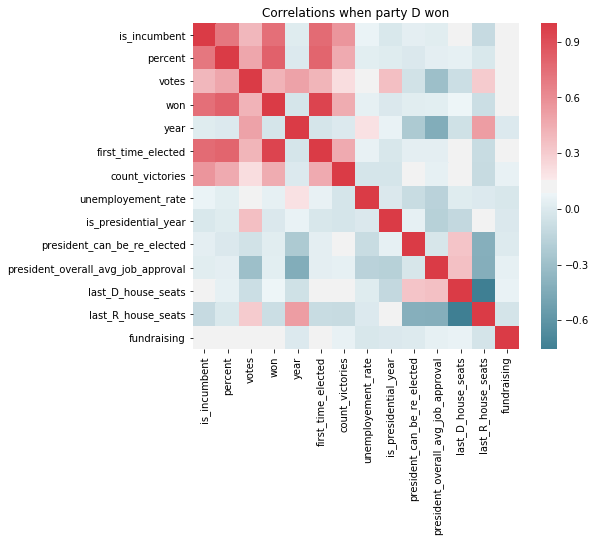

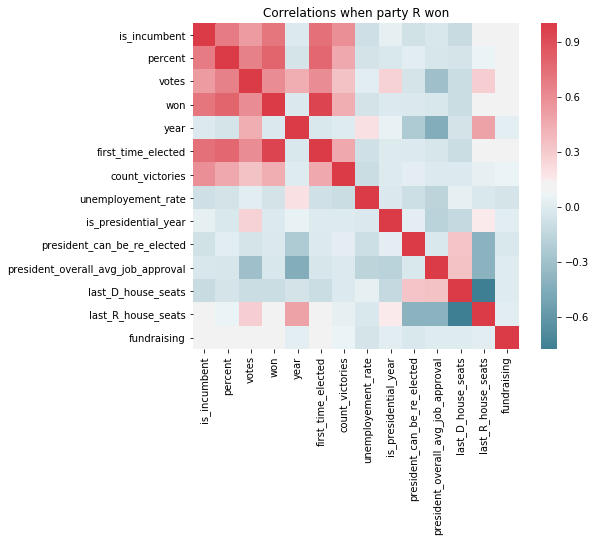

In [17]:
#Display correlations
corr_heat(house_df_mean[house_df_mean['year']!=2018], party='D')
corr_heat(house_df_mean[house_df_mean['year']!=2018], party='R')

# Variable Selection

In [18]:
#these are the categorical variables
cat_cols=['president_party','state','district','last_house_majority','name']

In [19]:
#one-hot-coding is necessary because of category variables
#because it is no ordinary data we cannot do label encoding. So we do one-hot-encoding
def one_hot_coding(data,cat_cols,y_year=2018):
    #returns x and y variables for test and train
    #data: dataframe
    #cat_cols: enter array with category columns
    #y_year: enter year for test data
    
    #create dummy features
    data = pd.get_dummies(data, columns=cat_cols)
    #create data sets for test and training
    sel_train, sel_test=data[data['year']!=y_year], data[data['year']==y_year]
    
    #split for x and y
    x_train, y_train=sel_train.drop('party', axis=1), sel_train['party']
    x_test, y_test=sel_test.drop('party', axis=1), sel_test['party']
    
    return x_train, y_train, x_test, y_test

### Variable Selection - categorical variables

In [20]:
#Chi Square Test
def chi2_test(x_col,y_col):
    x = x_col.astype(str)
    y= y_col.astype(str)

    obs_val = pd.crosstab(y,x)
    chi2, p, dof, expected = stats.chi2_contingency(obs_val.values)
    
    return chi2, p, dof

In [21]:
def print_chi2_result(data,y_col='party',cat_cols=cat_cols,alpha=0.05):
    for i in range(len(cat_cols)):
        chi2, p, dof = chi2_test(data[cat_cols[i]],data[y_col])
        if p>alpha:
            print('Important for the prediction model: {} (p-value: {:+.3f}, chi2: {:+.1f})'.format(cat_cols[i],p,chi2))
        else:
            print('\033[1mNOT\033[0m important for the prediction model: \033[1m{}\033[0m (p-value: {:+.3f}, chi2: {:+.1f})'.format(cat_cols[i],p,chi2))

In [22]:
#Print the result of Chi Square Test
print_chi2_result(house_df)

Important for the prediction model: president_party (p-value: +0.210, chi2: +3.1)
Important for the prediction model: state (p-value: +1.000, chi2: +19.7)
Important for the prediction model: district (p-value: +1.000, chi2: +14.7)
Important for the prediction model: last_house_majority (p-value: +0.314, chi2: +2.3)
NOT important for the prediction model: name (p-value: +0.000, chi2: +9955.0)


#### Interpretation: 
- Column "name" is not useful in the models
- But because of feature engineering during the modeling it will be needed

## Variable Selection - Random Forest with one-hot-coding 

In [23]:
#copy of original dataset
forest_df = house_df_mean.copy()

#Exclude column name because of low p-value - see chapter "Variable Selection - categorical variables"
forest_df = forest_df.drop(columns = 'name')

#categorical columns for Random Forest model
forest_cat=['president_party','state','district','last_house_majority']

In [24]:
def var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.003):
    #returns 1) sorted list of most important features
    #        2) Accuracy of model with all features and with selected features
    #thresold: minimum feature importance
    
    x_train, y_train, x_test, y_test = one_hot_coding(forest_df,forest_cat,y_year)
    
    # Create a random forest classifier. number of trees set to 100
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(x_train, y_train)
    feat_labels = x_train.columns
    feat_imp = []
    
    # name and gini importance of each feature
    for feature in zip(clf.feature_importances_,feat_labels):
        feat_imp.append(feature)
    feat_imp.sort(reverse=True)
    
    #sorted list with most important features
    feat_imp = list(filter(lambda x: x[0] > threshold, feat_imp))
    
    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than 0.003
    sfm = SelectFromModel(clf, threshold=threshold)

    # Train the selector
    sfm.fit(x_train, y_train)
    
    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    X_important_train = sfm.transform(x_train)
    X_important_test = sfm.transform(x_test)
    
    # Create a new random forest classifier for the most important features
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the new classifier on the new dataset containing the most important features
    clf_important.fit(X_important_train, y_train)
    
    # Accuracy of model with all features
    y_pred = clf.predict(x_test)
    print('Accuracy of model with all features: {:+.3f}'.format(accuracy_score(y_test, y_pred)))
    
    # Accuracy of model with most important features
    y_important_pred = clf_important.predict(X_important_test)
    print('Accuracy of model with most important features: {:+.3f}'.format(accuracy_score(y_test, y_important_pred)))
    
    return feat_imp

In [25]:
var_sel_RF(forest_df,forest_cat=forest_cat,y_year=2018, threshold=0.005)

Accuracy of model with all features: +0.754
Accuracy of model with most important features: +0.683


[(0.12887509285513132, 'percent'),
 (0.12211427246664142, 'votes'),
 (0.0915045815689258, 'fundraising'),
 (0.05292988093578521, 'unemployement_rate'),
 (0.05007418053233519, 'first_time_elected'),
 (0.03975649490654364, 'year'),
 (0.031002666065544072, 'last_D_house_seats'),
 (0.030495240178302283, 'last_R_house_seats'),
 (0.023551925361171365, 'count_victories'),
 (0.022220248454241392, 'president_overall_avg_job_approval'),
 (0.015216390095867081, 'state_California'),
 (0.014624051606127605, 'is_incumbent'),
 (0.01279188801836484, 'won'),
 (0.01090425880680488, 'district_District 1'),
 (0.010734454772533122, 'is_presidential_year'),
 (0.010715193184569984, 'district_District 2'),
 (0.008940875050554105, 'district_District 4'),
 (0.008605364653506718, 'state_Texas'),
 (0.00857605478759626, 'district_District 3'),
 (0.00752941926693872, 'state_New York'),
 (0.007336515171323253, 'district_District 6'),
 (0.007324742482375194, 'president_can_be_re_elected'),
 (0.007320299601452976, 'di

# Baseline Model

In [26]:
#further modeling for baseline with mean imputed data
house_df = house_df_mean.copy()

In [27]:
print(len(house_df))

9974


In [28]:
#check that we always have one (and only one) winner per district
house_df_grouped=house_df.groupby(['year', 'state', 'district'])['won'].sum().reset_index(drop=False)
house_df_grouped[house_df_grouped['won']!=1]

,year,state,district,won


In [29]:
#show that we have to remove first_time_elected if it's in the future, compared to current observation
house_df[(house_df['year']-house_df['first_time_elected']<=0)&(house_df['name']=='John Law')]

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
21,District 1,0.0,John Law,D,55.7,Indiana,13476.0,1,1860,1860.0,0,5.790196,1.0,1.0,R,0.525667,98.000000,116.000000,R,552917.8375


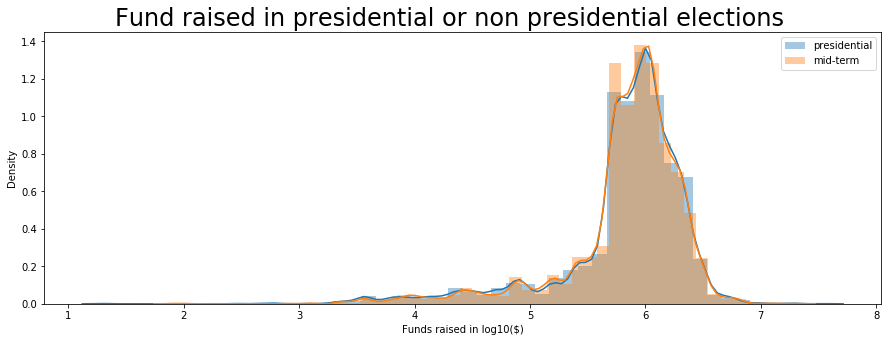

In [30]:
#fundraising
def fundraisingVsPresidentialYear(df):
    df_plt=df.dropna(subset=['fundraising', 'is_presidential_year']).copy()
    #df_plt.loc[df_plt['fundraising']<=0, 'fundraising']=1 #remove zero values
    df_plt=df_plt[df_plt['fundraising']>0]
    df_plt['fundraising']=np.log10(df_plt['fundraising']) #take the log10
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle('Fund raised in presidential or non presidential elections', fontsize=24, y=0.95)
    #print(i, year)
    sns.distplot(df_plt[df_plt['is_presidential_year']==1]['fundraising'], ax=ax, label='presidential')
    sns.distplot(df_plt[df_plt['is_presidential_year']==0]['fundraising'], ax=ax, label='mid-term')
    #set x label
    ax.set_xlabel('Funds raised in log10($)')
    #set y label
    ax.set_ylabel('Density')
    #set title
    #ax[i].set_title('year {}'.format(year))
    #set legend
    ax.legend()
fundraisingVsPresidentialYear(house_df)

In [31]:
house_df_district_count=house_df.loc[house_df['year']==2017]
house_df_district_count.groupby(['state', 'district'])['name'].first()

house_df[(house_df['state']=='California')&(house_df['district']=='District 34')&(house_df['year']==2017)]

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
9122,District 34,0.0,Robert Lee Ahn,D,40.8,California,17610.0,0,2017,0.0,0,6.8,0.0,1.0,0,0.515259,241.017241,193.724138,D,1658443.92
9126,District 34,0.0,Jimmy Gomez,D,59.2,California,25569.0,1,2017,2017.0,0,6.8,0.0,1.0,0,0.515259,241.017241,193.724138,D,1379556.75


In [32]:
#count how many observations we have for each district. 
house_df_grouped=house_df[house_df['year']!=2018].groupby(['state', 'district'])['party'].count()
house_df_grouped.reset_index(drop=False).head()

,state,district,party
0,Alabama,District 1,12
1,Alabama,District 2,16
2,Alabama,District 3,16
3,Alabama,District 4,12
4,Alabama,District 5,14


In [33]:
house_df2=house_df.copy()
house_df2['R_vs_D_Seats']=house_df2['last_R_house_seats']/(house_df2['last_R_house_seats']+house_df2['last_D_house_seats']) #1=100% R, 0=100% D
house_df2['WinLoseParty']=house_df2['party'].astype(str)+house_df2['won'].replace([0, 1], ['Loser', 'Winner'])
house_df2['won']=house_df2['won'].replace([0, 1], ['Loser', 'Winner'])
house_df2['LogFundraising']=house_df2['fundraising'].copy()
house_df2.loc[house_df2['LogFundraising']<=0, 'LogFundraising']=np.NaN
house_df2['LogFundraising']=np.log10(house_df2['LogFundraising']) #take the log10
#df['Year'].astype(str) + df['quarter']
house_df2.head()

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,...,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising,R_vs_D_Seats,WinLoseParty,LogFundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,Winner,1824,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,Winner,1826,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,Winner,1828,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,Loser,1830,1860.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DLoser,5.742661
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,Winner,1830,1824.0,...,1.0,0,0.525667,200.179856,182.503597,D,552917.8375,0.476905,DWinner,5.742661


In [34]:
#palettes for parties or other
Parties_palette=[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
             (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
             (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]
WinLosePalette=[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
             (1.0, 0.4980392156862745, 0.054901960784313725),
             (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
             (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
             (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
             (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
             (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
             (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


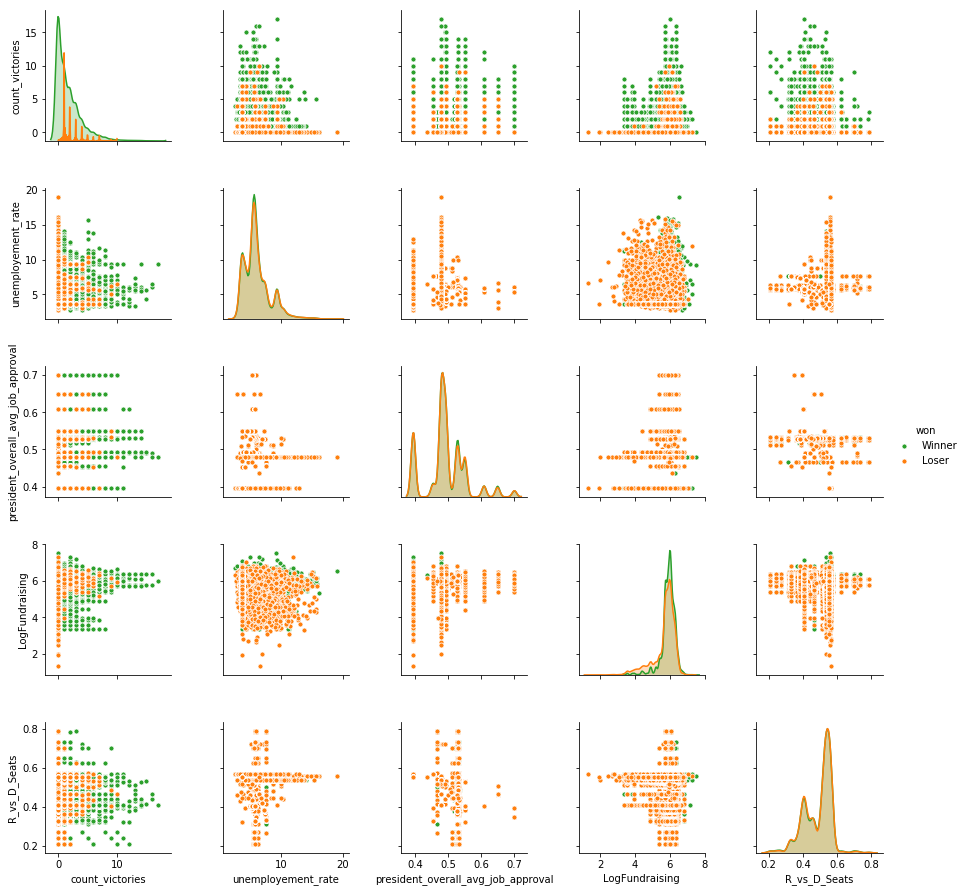

In [35]:
sns.pairplot(house_df2[[
 'party',
 'count_victories',
 'unemployement_rate',
 'president_party',
 'president_overall_avg_job_approval',
 'last_house_majority',
 'LogFundraising',
 #'WinLoseParty',
 #'wonParty',
 'R_vs_D_Seats',
 'won']], hue="won",  palette=WinLosePalette, plot_kws=dict(s=25))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


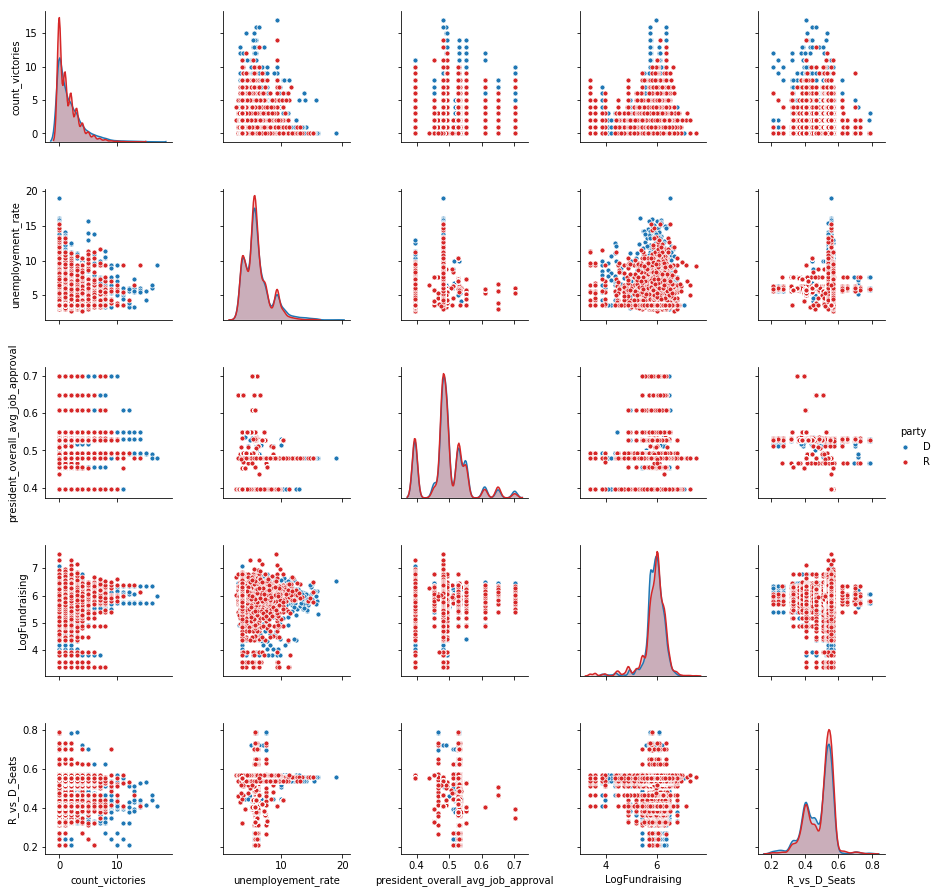

In [36]:
sns.pairplot(house_df2[house_df2['won']=='Winner'][[
 'party',
 'count_victories',
 'unemployement_rate',
 'president_party',
 'president_overall_avg_job_approval',
 'last_house_majority',
 'LogFundraising',
 #'WinLoseParty',
 #'wonParty',
 'R_vs_D_Seats',
 'won']], hue="party",  palette=Parties_palette, plot_kws=dict(s=25))

In [37]:
house_df2=house_df.dropna().copy()
house_df2_districts=house_df2[['state','district']]
house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])

data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

x_train, y_train=data_train.drop('won', axis=1), data_train['won']

x_test, y_test=data_test.drop('won', axis=1), data_test['won']
baselineLogRegr=LogisticRegressionCV(cv=5, penalty='l2').fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [38]:
#Accuracy is defined as (TP+TN)/n
def printAccuracy(y_train, y_pred_train, y_test, y_pred_test):
    print('Training Set Accuracy: \t{:.2%}'.format(np.sum(y_train == y_pred_train) / len(y_train)))
    print('Test Set Accuracy: \t{:.2%}'.format(np.sum(y_test == y_pred_test) / len(y_test)))

y_pred_train=baselineLogRegr.predict(x_train)
y_pred_test=baselineLogRegr.predict(x_test)
printAccuracy(y_train, y_pred_train, y_test, y_pred_test)
print('Amount of districts in the predictions: {:.1%} of the total'.format(len(x_test.join(house_df2_districts).groupby(['state', 'district']).count())/435))

Training Set Accuracy: 	97.38%
Test Set Accuracy: 	97.02%
Amount of districts in the predictions: 100.0% of the total


In [39]:
#Baseline model 
def winnerFilter(df):
    return df[df['won']==1][['state', 'district','party']]
    
def baselineTrain(df):
    df_grouped=df[df['won']==1 ].groupby(['state', 'district', 'party'])['won'].count().reset_index(drop=False)
    df_grouped=df_grouped.groupby(['state', 'district']).agg({'won':'max',      
                                         'party': 'first'})
    return df_grouped.drop('won', axis=1).reset_index(drop=False)

In [40]:
y_pred=baselineTrain(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
y=winnerFilter(house_df[house_df['year']==2018]) #extract winner party for each district in 2018

results=[]
for state in y['state'].unique():
    for district in y[y['state']==state]['district']:
        actual=y.loc[(y['state']==state)&(y['district']==district), 'party']
        pred=y_pred.loc[(y_pred['state']==state)&(y_pred['district']==district), 'party']
        #print('pred:{}, \nactual:{}, \npred.all():{}, \nactual.all():{}\n result:{}\n'.format(pred, actual, pred.all(), actual.all(), actual.all()==pred.all()))
        results.append(actual.all()==pred.all())
print('Test Set Accuracy: \t{:.2%}'.format(sum(results)/len(results)))

Test Set Accuracy: 	77.93%


In [41]:
# table with all correlations for Republicans win
drop = ['won','votes', 'percent', 'year', 'first_time_elected', 'is_presidential_year', 'last_D_house_seats', 'last_R_house_seats','president_can_be_re_elected']
corr_df = house_df2.copy()
corr_df = corr_df.drop(drop, axis=1)
corr_df[corr_df['party'] == 1].drop('party', axis=1).corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,is_incumbent,count_victories,unemployement_rate,president_party,president_overall_avg_job_approval,last_house_majority,fundraising
is_incumbent,1.0,0.6,-0.078,0.064,-0.039,0.091,0.14
count_victories,0.6,1.0,-0.11,0.069,-0.032,0.015,0.073
unemployement_rate,-0.078,-0.11,1.0,-0.42,0.04,-0.18,-0.038
president_party,0.064,0.069,-0.42,1.0,-0.19,0.25,-0.013
president_overall_avg_job_approval,-0.039,-0.032,0.04,-0.19,1.0,-0.43,0.012
last_house_majority,0.091,0.015,-0.18,0.25,-0.43,1.0,0.0031
fundraising,0.14,0.073,-0.038,-0.013,0.012,0.0031,1.0


In [42]:
# table with all correlations for Democrats win
corr_df[corr_df['party'] == 0].drop('party',axis=1).corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,is_incumbent,count_victories,unemployement_rate,president_party,president_overall_avg_job_approval,last_house_majority,fundraising
is_incumbent,1.0,0.57,0.074,-0.068,0.034,-0.12,0.12
count_victories,0.57,1.0,-0.029,0.031,0.046,-0.13,0.055
unemployement_rate,0.074,-0.029,1.0,-0.43,0.049,-0.16,-0.0099
president_party,-0.068,0.031,-0.43,1.0,-0.2,0.26,0.0022
president_overall_avg_job_approval,0.034,0.046,0.049,-0.2,1.0,-0.45,0.048
last_house_majority,-0.12,-0.13,-0.16,0.26,-0.45,1.0,-0.043
fundraising,0.12,0.055,-0.0099,0.0022,0.048,-0.043,1.0


In [43]:
var_all = ['last_house_majority','is_incumbent', 'count_victories','unemployement_rate', 'president_overall_avg_job_approval','fundraising']

# comparison of variables with boxplots
def expl_boxplots(dataframe,variables):
    house_df2_D = dataframe[dataframe['party'] == 0]
    house_df2_R = dataframe[dataframe['party'] == 1]
    fig = plt.figure(figsize=(10,6))
    for i in range(len(var_all)):
        plt.subplot(2,3,i+1)
        a = pd.DataFrame({ 'group' : np.repeat('Democrat',house_df2_D.shape[0]), 'value': house_df2_D[var_all[i]] })
        b = pd.DataFrame({ 'group' : np.repeat('Republican',house_df2_R.shape[0]), 'value': house_df2_R[var_all[i]] })
        plt.title(var_all[i])
        df=a.append(b)
        # boxplot with colors
        my_pal = {DEM_blue,REP_red}
        sns.boxplot(x='group', y='value', data=df,palette=my_pal)
    fig
    
    plt.tight_layout()


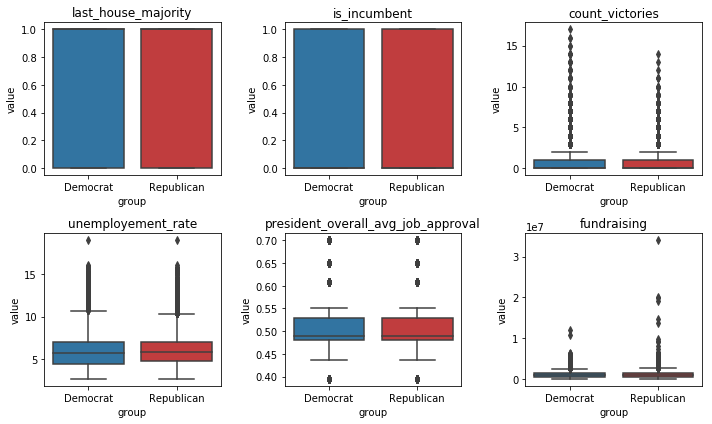

In [44]:
expl_boxplots(house_df2,var_all)